# Projet 7 : Implémenter un modèle de scoring

In [1]:
pip install lightgbm

You should consider upgrading via the '/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [121]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, plot_roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets, preprocessing, model_selection, ensemble, pipeline
import mlflow.pyfunc
import warnings
import math 
warnings.simplefilter(action='ignore', category=FutureWarning)
 

## Lecture et préparation des données 

In [3]:
# HOME CREDIT DEFAULT RISK COMPETITION
# Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
# Little feature selection is done and overfitting might be a problem since many features are related.
# The following key ideas were used:
# - Divide or subtract important features to get rates (like annuity and income)
# - In Bureau Data: create specific features for Active credits and Closed credits
# - In Previous Applications: create specific features for Approved and Refused applications
# - Modularity: one function for each table (except bureau_balance and application_test)
# - One-hot encoding for categorical features
# All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
# You can use LightGBM with KFold or Stratified KFold.

# Update 16/06/2018:
# - Added Payment Rate feature
# - Removed index from features
# - Use standard KFold CV (not stratified)


@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('input/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('input/application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('input/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('input/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('input/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('input/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('input/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('input/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg
    
def process_data(num_rows = None, nan_as_category = True, debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    return df 

df = process_data(num_rows = None, nan_as_category = True, debug = False)

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 11s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 9s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 5s
Installments payments df shape: (339587, 26)
Process installments payments - done in 15s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 10s


# Construction du modèle LightLGBM

In [4]:
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]
feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

In [5]:
train_df[train_df['TARGET']==0].shape

(282682, 798)

In [6]:
pip install lightgbm

You should consider upgrading via the '/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [7]:
# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code


def kfold_lightgbm(df, num_folds,  class_weight = None, is_unbalance = False, stratified = False, debug= False):
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    # Divide in training/validation and test data
    import re
    train_df = train_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    test_df = test_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    oof_class = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            class_weight = class_weight,
            is_unbalance = is_unbalance,
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        oof_class[valid_idx] = clf.predict(valid_x, num_iteration=clf.best_iteration_)
        
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    plot_roc_curve(clf, train_df[feats], train_df['TARGET'])
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv('test_preds', index= False)
    display_importances(feature_importance_df)
    
    return feature_importance_df, oof_preds, oof_class

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')




In [8]:
def plot_heatmap(y_true, y_pred, class_names, title):
    cm = confusion_matrix(y_true, y_pred)#, normalize = "true")
    #cm = cm*100
    ax = sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='.1f', 
        cmap='YlGnBu',
        cbar=False,
    )
    plt.title(title, fontsize=16)
    #set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 75)
    plt.ylabel('True Label', fontsize = 12)
    plt.xlabel('Predicted Label', fontsize=12)

In [9]:
from sklearn.metrics import classification_report
def evaluate_model(prob, classes):
    train_df = df[df['TARGET'].notnull()]
    feats = [f for f in train_df.columns if f not in [
        'TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]
    target_names = ['credit worthy', 'credit unworthy']

    print('******************** Full AUC score ***********************')
    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], prob))
    print('\n******************** Heatmap ***********************')
    plot_heatmap(train_df['TARGET'], classes, target_names, 'Heatmap')
    plt.show()
    print('\n******************** Classification report ***********************')
    print(classification_report(
        train_df['TARGET'], classes, target_names=target_names))

### 1- No stratification / is_unbalance = False / no class weights 

In [10]:
class_weight = None
stratified = None
is_unbalance = False 

Starting LightGBM. Train shape: (307507, 798), test shape: (48744, 798)


/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. P

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.803491	training's binary_logloss: 0.231992	valid_1's auc: 0.774499	valid_1's binary_logloss: 0.244831
[400]	training's auc: 0.829173	training's binary_logloss: 0.221118	valid_1's auc: 0.783877	valid_1's binary_logloss: 0.241055
[600]	training's auc: 0.846138	training's binary_logloss: 0.214031	valid_1's auc: 0.787004	valid_1's binary_logloss: 0.239953
[800]	training's auc: 0.859614	training's binary_logloss: 0.208255	valid_1's auc: 0.788082	valid_1's binary_logloss: 0.239541
[1000]	training's auc: 0.871649	training's binary_logloss: 0.203046	valid_1's auc: 0.788632	valid_1's binary_logloss: 0.239348
[1200]	training's auc: 0.882319	training's binary_logloss: 0.198164	valid_1's auc: 0.788856	valid_1's binary_logloss: 0.23926
[1400]	training's auc: 0.892621	training's binary_logloss: 0.193324	valid_1's auc: 0.788859	valid_1's binary_logloss: 0.2392

/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. P

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.802584	training's binary_logloss: 0.234872	valid_1's auc: 0.775702	valid_1's binary_logloss: 0.239398
[400]	training's auc: 0.827979	training's binary_logloss: 0.223921	valid_1's auc: 0.784971	valid_1's binary_logloss: 0.235603
[600]	training's auc: 0.844869	training's binary_logloss: 0.216828	valid_1's auc: 0.788387	valid_1's binary_logloss: 0.234295
[800]	training's auc: 0.858447	training's binary_logloss: 0.210996	valid_1's auc: 0.789774	valid_1's binary_logloss: 0.233779
[1000]	training's auc: 0.870438	training's binary_logloss: 0.205688	valid_1's auc: 0.790243	valid_1's binary_logloss: 0.23357
[1200]	training's auc: 0.881607	training's binary_logloss: 0.200466	valid_1's auc: 0.790482	valid_1's binary_logloss: 0.233431
Fold  2 AUC : 0.790523


/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. P

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.803148	training's binary_logloss: 0.233409	valid_1's auc: 0.774036	valid_1's binary_logloss: 0.242432
[400]	training's auc: 0.828377	training's binary_logloss: 0.222596	valid_1's auc: 0.783726	valid_1's binary_logloss: 0.238443
[600]	training's auc: 0.84574	training's binary_logloss: 0.215357	valid_1's auc: 0.786914	valid_1's binary_logloss: 0.237275
[800]	training's auc: 0.859786	training's binary_logloss: 0.209466	valid_1's auc: 0.78834	valid_1's binary_logloss: 0.236753
[1000]	training's auc: 0.871983	training's binary_logloss: 0.204058	valid_1's auc: 0.789118	valid_1's binary_logloss: 0.236478
[1200]	training's auc: 0.882592	training's binary_logloss: 0.199182	valid_1's auc: 0.789525	valid_1's binary_logloss: 0.23632
[1400]	training's auc: 0.892133	training's binary_logloss: 0.194573	valid_1's auc: 0.789601	valid_1's binary_logloss: 0.236277

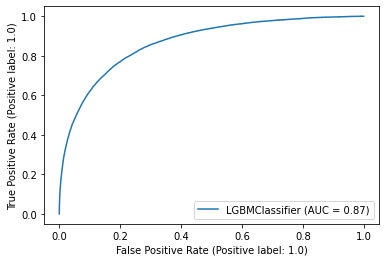

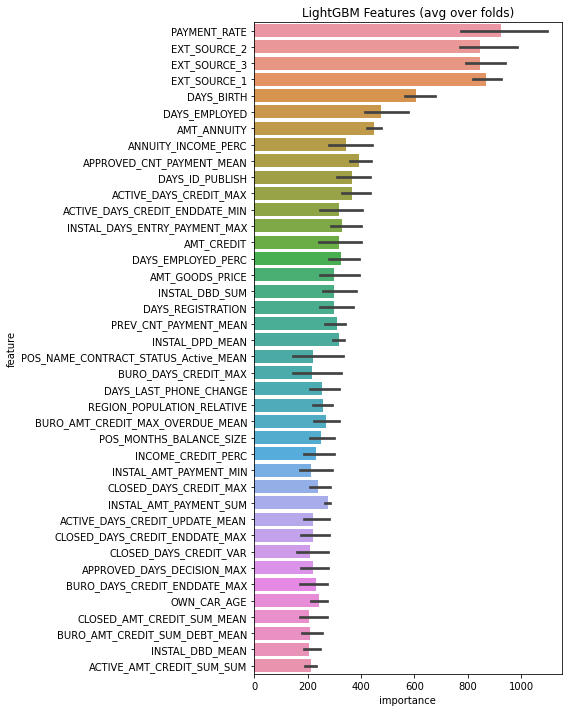

In [11]:
feature_importance_df, prob1, classes1 = kfold_lightgbm(
    df, num_folds = 3,  class_weight=class_weight, is_unbalance = is_unbalance, stratified=stratified, debug=False)

stratified for unbalanced data -> gives train and test datasets that reflect the distribution of negative and positive classes in the original dataset 

class weights parameter in lightGBM : attribute diff weights to the pos and neg class, so that an error of prediction for the negative class is more penalized during the training than an eror of prediction for the pos class. 



******************** Full AUC score ***********************
Full AUC score 0.789632

******************** Heatmap ***********************


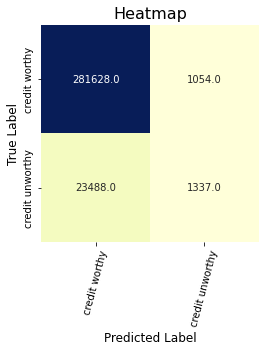


******************** Classification report ***********************
                 precision    recall  f1-score   support

  credit worthy       0.92      1.00      0.96    282682
credit unworthy       0.56      0.05      0.10     24825

       accuracy                           0.92    307507
      macro avg       0.74      0.53      0.53    307507
   weighted avg       0.89      0.92      0.89    307507



In [12]:
evaluate_model(prob1, classes1)

### stratification / is_unbalance = False / no class weights 

In [13]:
class_weight = None
stratified = True
is_unbalance = False

Starting LightGBM. Train shape: (307507, 798), test shape: (48744, 798)


/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. P

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.802745	training's binary_logloss: 0.233456	valid_1's auc: 0.771111	valid_1's binary_logloss: 0.242815
[400]	training's auc: 0.828605	training's binary_logloss: 0.222435	valid_1's auc: 0.782003	valid_1's binary_logloss: 0.23867
[600]	training's auc: 0.845564	training's binary_logloss: 0.215378	valid_1's auc: 0.785713	valid_1's binary_logloss: 0.237401
[800]	training's auc: 0.859455	training's binary_logloss: 0.209441	valid_1's auc: 0.787254	valid_1's binary_logloss: 0.236856
[1000]	training's auc: 0.871834	training's binary_logloss: 0.204003	valid_1's auc: 0.787847	valid_1's binary_logloss: 0.236659
[1200]	training's auc: 0.882477	training's binary_logloss: 0.199055	valid_1's auc: 0.788184	valid_1's binary_logloss: 0.236531
[1400]	training's auc: 0.892193	training's binary_logloss: 0.194369	valid_1's auc: 0.78822	valid_1's binary_logloss: 0.23651

/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. P

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.803059	training's binary_logloss: 0.233369	valid_1's auc: 0.774837	valid_1's binary_logloss: 0.242219
[400]	training's auc: 0.827904	training's binary_logloss: 0.222576	valid_1's auc: 0.784728	valid_1's binary_logloss: 0.238265
[600]	training's auc: 0.845137	training's binary_logloss: 0.215485	valid_1's auc: 0.787872	valid_1's binary_logloss: 0.237102
[800]	training's auc: 0.859624	training's binary_logloss: 0.20949	valid_1's auc: 0.789064	valid_1's binary_logloss: 0.236644
[1000]	training's auc: 0.872066	training's binary_logloss: 0.204048	valid_1's auc: 0.789834	valid_1's binary_logloss: 0.236384
[1200]	training's auc: 0.882875	training's binary_logloss: 0.199093	valid_1's auc: 0.790108	valid_1's binary_logloss: 0.236269
[1400]	training's auc: 0.892862	training's binary_logloss: 0.194283	valid_1's auc: 0.790215	valid_1's binary_logloss: 0.2362

/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. P

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.802862	training's binary_logloss: 0.233412	valid_1's auc: 0.776693	valid_1's binary_logloss: 0.241972
[400]	training's auc: 0.8282	training's binary_logloss: 0.222616	valid_1's auc: 0.78555	valid_1's binary_logloss: 0.238268
[600]	training's auc: 0.845215	training's binary_logloss: 0.215574	valid_1's auc: 0.788278	valid_1's binary_logloss: 0.237146
[800]	training's auc: 0.859386	training's binary_logloss: 0.20968	valid_1's auc: 0.789531	valid_1's binary_logloss: 0.236637
[1000]	training's auc: 0.871634	training's binary_logloss: 0.204299	valid_1's auc: 0.789909	valid_1's binary_logloss: 0.236435
[1200]	training's auc: 0.882405	training's binary_logloss: 0.199282	valid_1's auc: 0.789802	valid_1's binary_logloss: 0.236425
Fold  3 AUC : 0.789986
Full AUC score 0.789492


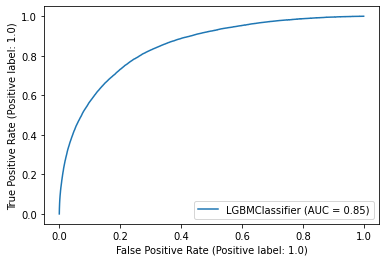

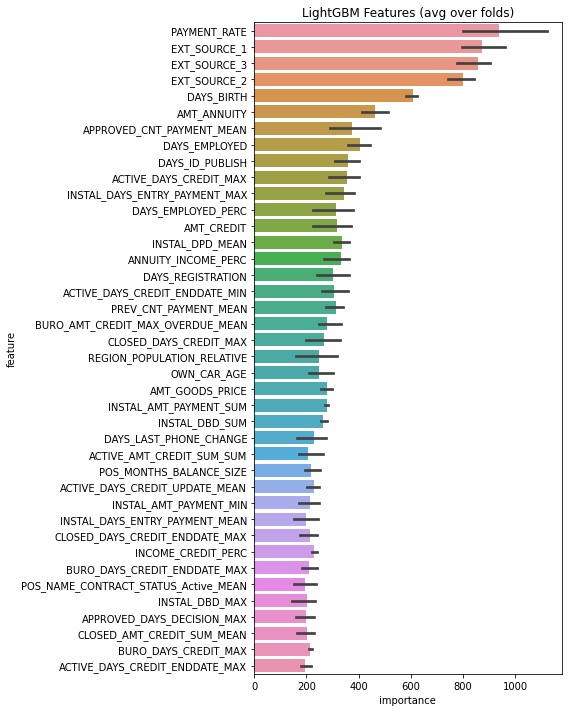

In [14]:
feature_importance_df, prob2, classes2 = kfold_lightgbm(
    df, num_folds = 3,  class_weight=class_weight, is_unbalance = is_unbalance, stratified=stratified, debug=False)

******************** Full AUC score ***********************
Full AUC score 0.789492

******************** Heatmap ***********************


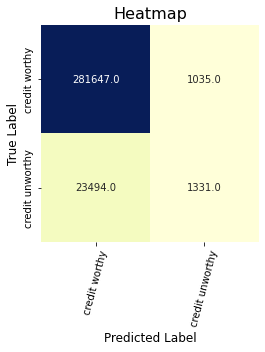


******************** Classification report ***********************
                 precision    recall  f1-score   support

  credit worthy       0.92      1.00      0.96    282682
credit unworthy       0.56      0.05      0.10     24825

       accuracy                           0.92    307507
      macro avg       0.74      0.52      0.53    307507
   weighted avg       0.89      0.92      0.89    307507



In [15]:
evaluate_model(prob2, classes2)

### stratification / is_unbalance = True / no class weights 

In [16]:
class_weight = None
stratified = True
is_unbalance = True

Starting LightGBM. Train shape: (307507, 798), test shape: (48744, 798)


/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. P

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.811493	training's binary_logloss: 0.53492	valid_1's auc: 0.772311	valid_1's binary_logloss: 0.544614
Fold  1 AUC : 0.720696


/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. P

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.811081	training's binary_logloss: 0.535529	valid_1's auc: 0.77612	valid_1's binary_logloss: 0.540884
Fold  2 AUC : 0.727954


/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. P

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.811297	training's binary_logloss: 0.535458	valid_1's auc: 0.777155	valid_1's binary_logloss: 0.546089
Fold  3 AUC : 0.731283
Full AUC score 0.726694


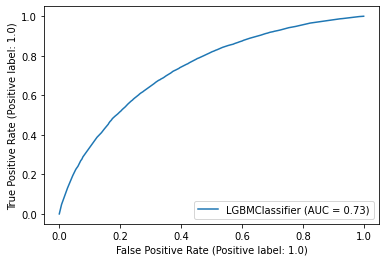

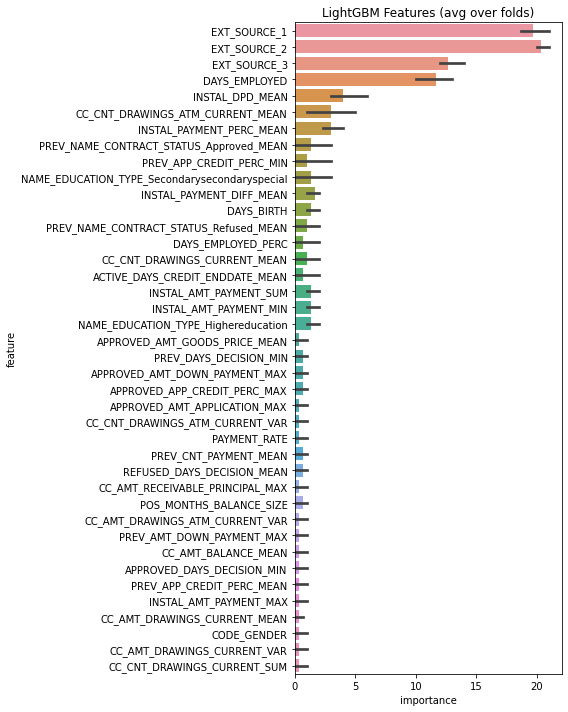

In [17]:
feature_importance_df, prob3, classes3 = kfold_lightgbm(
    df, num_folds = 3,  class_weight=class_weight, is_unbalance = is_unbalance, stratified=stratified, debug=False)

******************** Full AUC score ***********************
Full AUC score 0.726694

******************** Heatmap ***********************


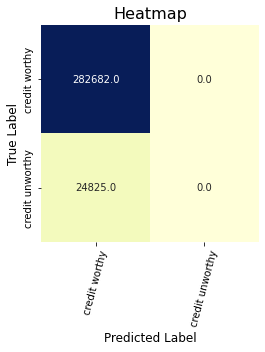


******************** Classification report ***********************


/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                 precision    recall  f1-score   support

  credit worthy       0.92      1.00      0.96    282682
credit unworthy       0.00      0.00      0.00     24825

       accuracy                           0.92    307507
      macro avg       0.46      0.50      0.48    307507
   weighted avg       0.85      0.92      0.88    307507



/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
evaluate_model(prob3, classes3)

### stratification / is_unbalance = False / class weights 

In [19]:
class_weight = 'balanced'
stratified = True
is_unbalance = False

Starting LightGBM. Train shape: (307507, 798), test shape: (48744, 798)


/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. P

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.805312	training's binary_logloss: 0.549063	valid_1's auc: 0.769858	valid_1's binary_logloss: 0.55995
[400]	training's auc: 0.834146	training's binary_logloss: 0.513575	valid_1's auc: 0.780403	valid_1's binary_logloss: 0.533527
[600]	training's auc: 0.854161	training's binary_logloss: 0.489842	valid_1's auc: 0.783883	valid_1's binary_logloss: 0.517522
[800]	training's auc: 0.870742	training's binary_logloss: 0.470286	valid_1's auc: 0.785185	valid_1's binary_logloss: 0.504899
[1000]	training's auc: 0.884564	training's binary_logloss: 0.453382	valid_1's auc: 0.785337	valid_1's binary_logloss: 0.494126
Fold  1 AUC : 0.785422


/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. P

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.805403	training's binary_logloss: 0.549458	valid_1's auc: 0.773866	valid_1's binary_logloss: 0.556394
[400]	training's auc: 0.83366	training's binary_logloss: 0.51433	valid_1's auc: 0.784063	valid_1's binary_logloss: 0.529774
[600]	training's auc: 0.853987	training's binary_logloss: 0.490623	valid_1's auc: 0.786895	valid_1's binary_logloss: 0.514227
[800]	training's auc: 0.870821	training's binary_logloss: 0.470874	valid_1's auc: 0.787742	valid_1's binary_logloss: 0.501781
[1000]	training's auc: 0.885353	training's binary_logloss: 0.453308	valid_1's auc: 0.787817	valid_1's binary_logloss: 0.490704
Fold  2 AUC : 0.787903


/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. P

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.805202	training's binary_logloss: 0.549627	valid_1's auc: 0.775691	valid_1's binary_logloss: 0.56125
[400]	training's auc: 0.833913	training's binary_logloss: 0.514113	valid_1's auc: 0.785278	valid_1's binary_logloss: 0.535189
[600]	training's auc: 0.854361	training's binary_logloss: 0.490222	valid_1's auc: 0.78763	valid_1's binary_logloss: 0.519416
[800]	training's auc: 0.871053	training's binary_logloss: 0.470659	valid_1's auc: 0.788253	valid_1's binary_logloss: 0.506965
[1000]	training's auc: 0.885724	training's binary_logloss: 0.452898	valid_1's auc: 0.788294	valid_1's binary_logloss: 0.495902
Fold  3 AUC : 0.788465
Full AUC score 0.787243


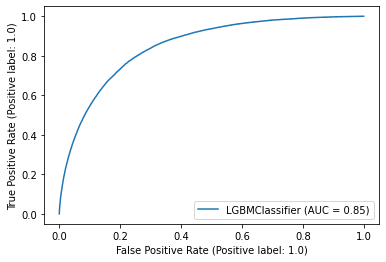

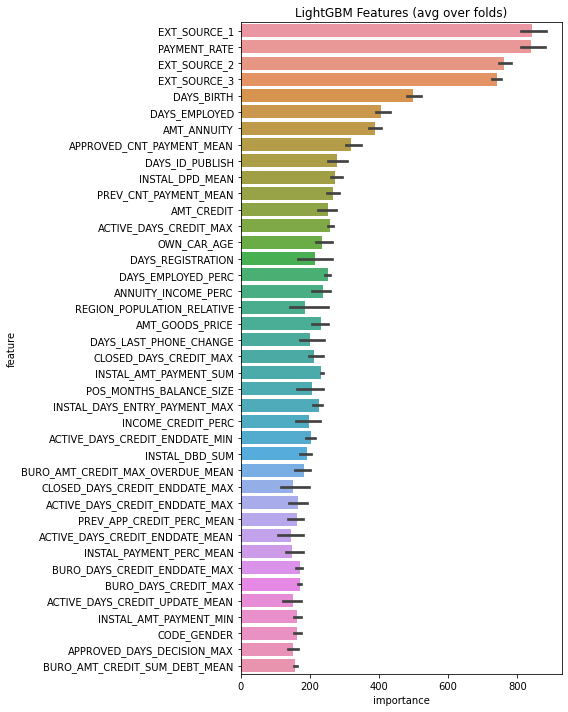

In [20]:
feature_importance_df, prob5, classes5 = kfold_lightgbm(
    df, num_folds=3,  class_weight=class_weight, is_unbalance=is_unbalance, stratified=stratified, debug=False)

******************** Full AUC score ***********************
Full AUC score 0.787243

******************** Heatmap ***********************


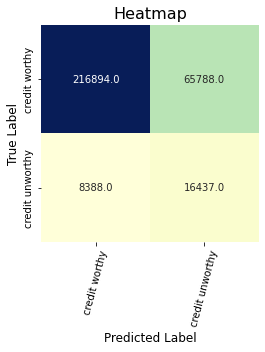


******************** Classification report ***********************
                 precision    recall  f1-score   support

  credit worthy       0.96      0.77      0.85    282682
credit unworthy       0.20      0.66      0.31     24825

       accuracy                           0.76    307507
      macro avg       0.58      0.71      0.58    307507
   weighted avg       0.90      0.76      0.81    307507



In [21]:
evaluate_model(prob5, classes5)

In [22]:
from sklearn.metrics import roc_curve
[fpr, tpr, thr] = roc_curve(train_df['TARGET'], prob5)
# indice du premier seuil pour lequel
# la sensibilité est supérieure à 0.95
idx = np.min(np.where(tpr > 0.9)) 

print("Sensibilité : {:.2f}".format(tpr[idx]))
print("Spécificité : {:.2f}".format(1-fpr[idx]))
print("Seuil : {:.2f}".format(thr[idx]))

Sensibilité : 0.90
Spécificité : 0.44
Seuil : 0.26


### stratification / is_unbalance = True / class weights 

In [23]:
class_weight = 'balanced'
stratified = False
is_unbalance = True

Starting LightGBM. Train shape: (307507, 798), test shape: (48744, 798)


/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. P

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.797138	training's binary_logloss: 0.996439	valid_1's auc: 0.758729	valid_1's binary_logloss: 1.76693
Fold  1 AUC : 0.695892


/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. P

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.796385	training's binary_logloss: 0.994794	valid_1's auc: 0.76193	valid_1's binary_logloss: 1.76926
Fold  2 AUC : 0.695277


/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. P

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.795196	training's binary_logloss: 0.996884	valid_1's auc: 0.757559	valid_1's binary_logloss: 1.77179
Fold  3 AUC : 0.700840
Full AUC score 0.698925


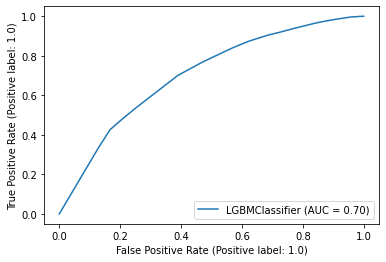

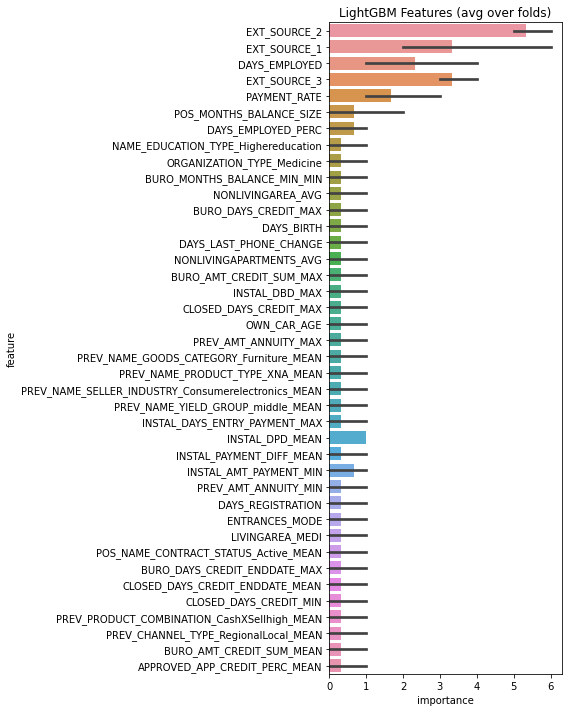

In [24]:
feature_importance_df, prob6, classes6 = kfold_lightgbm(
    df, num_folds=3,  class_weight=class_weight, is_unbalance=is_unbalance, stratified=stratified, debug=False)

******************** Full AUC score ***********************
Full AUC score 0.698925

******************** Heatmap ***********************


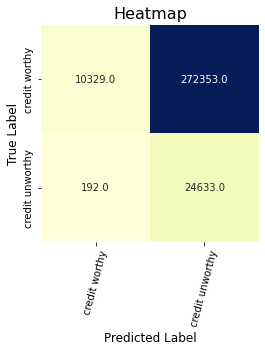


******************** Classification report ***********************
                 precision    recall  f1-score   support

  credit worthy       0.98      0.04      0.07    282682
credit unworthy       0.08      0.99      0.15     24825

       accuracy                           0.11    307507
      macro avg       0.53      0.51      0.11    307507
   weighted avg       0.91      0.11      0.08    307507



In [25]:
evaluate_model(prob6, classes6)

### stratification / is_unbalance = False / class weights 

In [26]:
class_weight = 'balanced'
stratified = True
is_unbalance = False

Starting LightGBM. Train shape: (307507, 798), test shape: (48744, 798)


/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. P

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.805312	training's binary_logloss: 0.549063	valid_1's auc: 0.769858	valid_1's binary_logloss: 0.55995
[400]	training's auc: 0.834146	training's binary_logloss: 0.513575	valid_1's auc: 0.780403	valid_1's binary_logloss: 0.533527
[600]	training's auc: 0.854161	training's binary_logloss: 0.489842	valid_1's auc: 0.783883	valid_1's binary_logloss: 0.517522
[800]	training's auc: 0.870742	training's binary_logloss: 0.470286	valid_1's auc: 0.785185	valid_1's binary_logloss: 0.504899
[1000]	training's auc: 0.884564	training's binary_logloss: 0.453382	valid_1's auc: 0.785337	valid_1's binary_logloss: 0.494126
Fold  1 AUC : 0.785422


/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. P

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.805403	training's binary_logloss: 0.549458	valid_1's auc: 0.773866	valid_1's binary_logloss: 0.556394
[400]	training's auc: 0.83366	training's binary_logloss: 0.51433	valid_1's auc: 0.784063	valid_1's binary_logloss: 0.529774
[600]	training's auc: 0.853987	training's binary_logloss: 0.490623	valid_1's auc: 0.786895	valid_1's binary_logloss: 0.514227
[800]	training's auc: 0.870821	training's binary_logloss: 0.470874	valid_1's auc: 0.787742	valid_1's binary_logloss: 0.501781
[1000]	training's auc: 0.885353	training's binary_logloss: 0.453308	valid_1's auc: 0.787817	valid_1's binary_logloss: 0.490704
Fold  2 AUC : 0.787903


/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. P

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.805202	training's binary_logloss: 0.549627	valid_1's auc: 0.775691	valid_1's binary_logloss: 0.56125
[400]	training's auc: 0.833913	training's binary_logloss: 0.514113	valid_1's auc: 0.785278	valid_1's binary_logloss: 0.535189
[600]	training's auc: 0.854361	training's binary_logloss: 0.490222	valid_1's auc: 0.78763	valid_1's binary_logloss: 0.519416
[800]	training's auc: 0.871053	training's binary_logloss: 0.470659	valid_1's auc: 0.788253	valid_1's binary_logloss: 0.506965
[1000]	training's auc: 0.885724	training's binary_logloss: 0.452898	valid_1's auc: 0.788294	valid_1's binary_logloss: 0.495902
Fold  3 AUC : 0.788465
Full AUC score 0.787243


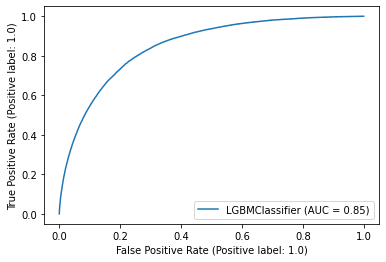

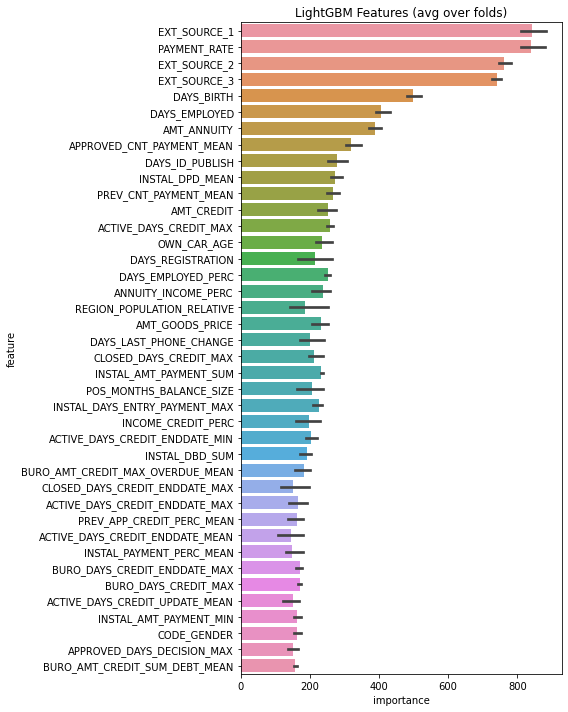

In [27]:
feature_importance_df4, prob4, classes4 = kfold_lightgbm(
    df, num_folds = 3,  class_weight=class_weight, is_unbalance = is_unbalance, stratified=stratified, debug=False)

******************** Full AUC score ***********************
Full AUC score 0.787243

******************** Heatmap ***********************


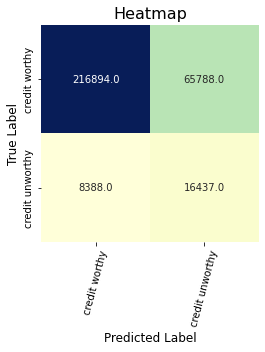


******************** Classification report ***********************
                 precision    recall  f1-score   support

  credit worthy       0.96      0.77      0.85    282682
credit unworthy       0.20      0.66      0.31     24825

       accuracy                           0.76    307507
      macro avg       0.58      0.71      0.58    307507
   weighted avg       0.90      0.76      0.81    307507



In [28]:
evaluate_model(prob4, classes4)

#### Drop highly correlated columns 

* We drop columns that are highly correlated, while making sure beforehand that these columns do not represent one of the 100 most important features 

In [29]:
corr = df.corr()

In [30]:
corr = corr.abs()
upper_tri = corr.where(np.triu(np.ones(corr.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
len(to_drop)

/var/folders/6r/bs3dqd0j5xn9pj7hgtmw69j00000gn/T/ipykernel_4084/1127735049.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = corr.where(np.triu(np.ones(corr.shape),k=1).astype(np.bool))


132

In [31]:
feature_importance = feature_importance_df4[feature_importance_df4['fold']==3][['feature', 'importance']]
feature_importance_max = feature_importance.sort_values(by = 'importance', ascending = False)[:100]
to_drop_imp = [feature for feature in to_drop if feature in feature_importance_max]
to_drop_imp

[]

In [32]:
df_cr = df.drop(columns = to_drop)
df_cr.shape

(356251, 666)

#### Run model with df_cr 

In [33]:
class_weight = 'balanced'
stratified = True
is_unbalance = False

Starting LightGBM. Train shape: (307507, 666), test shape: (48744, 666)


/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. P

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.804587	training's binary_logloss: 0.54955	valid_1's auc: 0.769682	valid_1's binary_logloss: 0.560326
[400]	training's auc: 0.833144	training's binary_logloss: 0.514532	valid_1's auc: 0.780308	valid_1's binary_logloss: 0.534214
[600]	training's auc: 0.85311	training's binary_logloss: 0.491036	valid_1's auc: 0.78358	valid_1's binary_logloss: 0.518357
[800]	training's auc: 0.869678	training's binary_logloss: 0.471574	valid_1's auc: 0.784787	valid_1's binary_logloss: 0.505815
[1000]	training's auc: 0.883739	training's binary_logloss: 0.454438	valid_1's auc: 0.785258	valid_1's binary_logloss: 0.494894
[1200]	training's auc: 0.89584	training's binary_logloss: 0.439124	valid_1's auc: 0.785096	valid_1's binary_logloss: 0.485191
Fold  1 AUC : 0.785286


/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. P

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.804354	training's binary_logloss: 0.550291	valid_1's auc: 0.773206	valid_1's binary_logloss: 0.557083
[400]	training's auc: 0.83241	training's binary_logloss: 0.515674	valid_1's auc: 0.783438	valid_1's binary_logloss: 0.531005
[600]	training's auc: 0.852543	training's binary_logloss: 0.492129	valid_1's auc: 0.786522	valid_1's binary_logloss: 0.515361
[800]	training's auc: 0.869194	training's binary_logloss: 0.472649	valid_1's auc: 0.787145	valid_1's binary_logloss: 0.50303
[1000]	training's auc: 0.8836	training's binary_logloss: 0.45534	valid_1's auc: 0.787458	valid_1's binary_logloss: 0.491991
[1200]	training's auc: 0.89594	training's binary_logloss: 0.439761	valid_1's auc: 0.787655	valid_1's binary_logloss: 0.482004
Fold  2 AUC : 0.787689


/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. P

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.804583	training's binary_logloss: 0.550161	valid_1's auc: 0.774942	valid_1's binary_logloss: 0.562007
[400]	training's auc: 0.832997	training's binary_logloss: 0.51512	valid_1's auc: 0.784184	valid_1's binary_logloss: 0.536486
[600]	training's auc: 0.85319	training's binary_logloss: 0.491576	valid_1's auc: 0.786808	valid_1's binary_logloss: 0.520939
[800]	training's auc: 0.869909	training's binary_logloss: 0.472126	valid_1's auc: 0.787513	valid_1's binary_logloss: 0.508554
[1000]	training's auc: 0.884426	training's binary_logloss: 0.454611	valid_1's auc: 0.787434	valid_1's binary_logloss: 0.497516
Fold  3 AUC : 0.787674
Full AUC score 0.786743


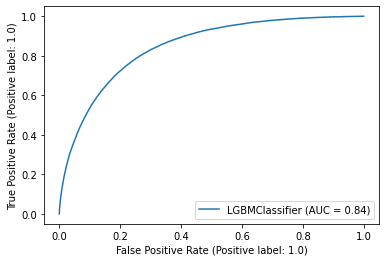

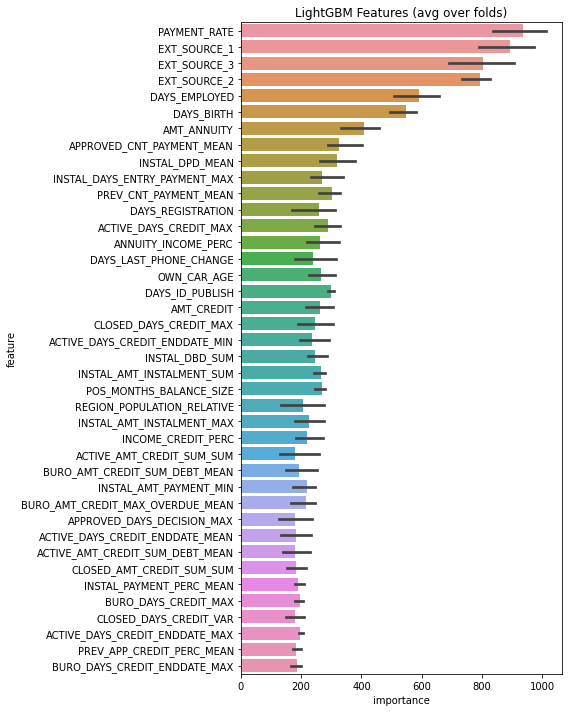

In [34]:
feature_importance_df_cr, prob_cr, classes_cr = kfold_lightgbm(
    df_cr, num_folds = 3,  class_weight=class_weight, is_unbalance = is_unbalance, stratified=stratified, debug=False)

******************** Full AUC score ***********************
Full AUC score 0.786743

******************** Heatmap ***********************


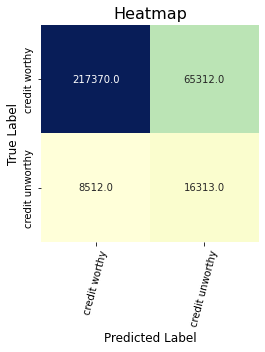


******************** Classification report ***********************
                 precision    recall  f1-score   support

  credit worthy       0.96      0.77      0.85    282682
credit unworthy       0.20      0.66      0.31     24825

       accuracy                           0.76    307507
      macro avg       0.58      0.71      0.58    307507
   weighted avg       0.90      0.76      0.81    307507



In [35]:
evaluate_model(prob_cr, classes_cr)

### Feature importance using RandomForest

In [36]:
from sklearn.impute import SimpleImputer
train = df[df['TARGET'].notnull()]
col = ['TARGET', 'index', 'SK_ID_CURR']
train_y_rf = train['TARGET']
train.drop(columns = col, inplace = True)
train.replace([np.inf, -np.inf], np.nan, inplace=True)
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(train)
train_x_rf = imp.transform(train)

/var/folders/6r/bs3dqd0j5xn9pj7hgtmw69j00000gn/T/ipykernel_4084/1090701876.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop(columns = col, inplace = True)
/var/folders/6r/bs3dqd0j5xn9pj7hgtmw69j00000gn/T/ipykernel_4084/1090701876.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.replace([np.inf, -np.inf], np.nan, inplace=True)


In [37]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(random_state=0)
forest.fit(train_x_rf, train_y_rf)

RandomForestClassifier(random_state=0)

In [38]:
import time

start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.040 seconds


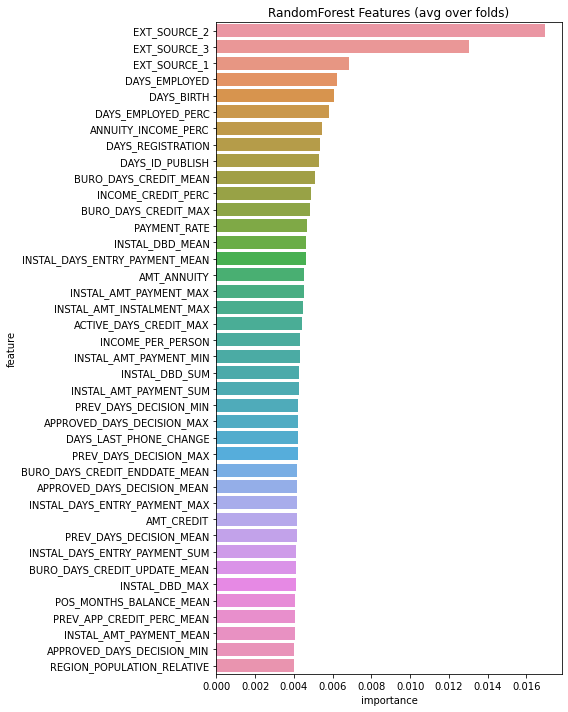

In [39]:
importance_df = pd.DataFrame()
index = train.columns
importance_df["feature"] = index
importance_df["importance"] = importances

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('RandomForest Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('rf_importances01.png')
    
display_importances(importance_df)

## Choice of features 

In [40]:
importance_lightgbm = feature_importance_df_cr[feature_importance_df_cr['fold'] == 3].sort_values(by=['importance'],
                                                                                                  ascending=False)['feature'][:15]

importance_rf = importance_df.sort_values(by=['importance'],
                                          ascending=False)['feature'][:15]

intersect = importance_rf[importance_rf.isin(importance_lightgbm)]
not_intersect = pd.concat([importance_rf[~importance_rf.isin(
    importance_lightgbm)], importance_lightgbm[~importance_lightgbm.isin(importance_rf)]])
print("******** common features in top 15 important features *********")
print(intersect)
print("********* features in top 15 important features not present in both models *********")
print(not_intersect)

******** common features in top 15 important features *********
31        EXT_SOURCE_2
32        EXT_SOURCE_3
30        EXT_SOURCE_1
10       DAYS_EMPLOYED
9           DAYS_BIRTH
12     DAYS_ID_PUBLISH
244       PAYMENT_RATE
Name: feature, dtype: object
********* features in top 15 important features not present in both models *********
240                DAYS_EMPLOYED_PERC
243               ANNUITY_INCOME_PERC
11                  DAYS_REGISTRATION
247             BURO_DAYS_CREDIT_MEAN
241                INCOME_CREDIT_PERC
246              BURO_DAYS_CREDIT_MAX
633                   INSTAL_DBD_MEAN
651    INSTAL_DAYS_ENTRY_PAYMENT_MEAN
6                         AMT_ANNUITY
509         APPROVED_CNT_PAYMENT_MEAN
538           POS_MONTHS_BALANCE_SIZE
554                   INSTAL_DPD_MEAN
339             PREV_CNT_PAYMENT_MEAN
270            ACTIVE_DAYS_CREDIT_MAX
568         INSTAL_AMT_INSTALMENT_SUM
570     INSTAL_DAYS_ENTRY_PAYMENT_MAX
Name: feature, dtype: object


* The features that are selected to built the final model are as follows : 
 * DAYS_BIRTH: Client's age in days at the time of application
 * DAYS_EMPLOYED: How many days before the application the person started current employment
 * DAYS_ID_PUBLISH: How many days before the application did client change the identity document with which he applied for the loan
 * EXT_SOURCE_X: Normalized score from external data source
 * PAYMENT_RATE: (AMT_ANNUITY / AMT_CREDIT) Payment rate for application
 * INSTAL_DPD_MEAN: (DPD : DAYS PAYMENT DUE, 0 means payment on time, x means the borrower paid x days after the payment was due) Average DPD for previous installments with home credit 
 * ANNUITY_INCOME_PERC: (AMT_ANNUITY / AMT_INCOME_TOTAL) Annuity expressed as a percentage of total income 
 * BURO_DAYS_CREDIT_MEAN: Date of last credit with bureau, expressed as number of days before today 

In [41]:
features_select = ["SK_ID_CURR", "EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3",
                   "DAYS_EMPLOYED", "DAYS_BIRTH", "DAYS_ID_PUBLISH", "PAYMENT_RATE", "INSTAL_DPD_MEAN", "ANNUITY_INCOME_PERC", "BURO_DAYS_CREDIT_MEAN"]
df_final = df[features_select + ["TARGET"]]

## Building the pipeline

In [42]:
LGBM_params = {
 'class_weight' : 'balanced',
 'is_unbalance': False,
'nthread' : 4,
   'n_estimators' : 10000,
   'learning_rate' : 0.02,
   'num_leaves' : 34,
   'colsample_bytree' : 0.9497036,
   'subsample' : 0.8715623,
   'max_depth' : 8,
   'reg_alpha' : 0.041545473,
   'reg_lambda' : 0.0735294,
   'min_split_gain' : 0.0222415,
   'min_child_weight' : 39.3259775,
   'silent' : -1,
   'verbose' : -1}

In [43]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([('scaler', preprocessing.StandardScaler()),
                              ('regressor', LGBMClassifier(**LGBM_params))])
folds = StratifiedKFold(n_splits= 3, shuffle=True, random_state=1001)
feats = [f for f in df_final.columns if f not in ['TARGET','SK_ID_CURR']]

train_df = df_final[df_final['TARGET'].notnull()]
test_df = df_final[df_final['TARGET'].isnull()]
 
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
    train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
    valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]
    
    pipe.fit(train_x, train_y, regressor__eval_set=[(train_x, train_y), (valid_x, valid_y)],
    regressor__eval_metric= 'auc', regressor__verbose= 200, regressor__early_stopping_rounds= 200)

/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. P

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	valid_0's auc: 0.60624	valid_0's binary_logloss: 0.443961	valid_1's auc: 0.601151	valid_1's binary_logloss: 0.444453


/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. P

[200]	valid_0's auc: 0.552015	valid_0's binary_logloss: 0.422284	valid_1's auc: 0.555743	valid_1's binary_logloss: 0.422395


/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. P

[200]	valid_0's auc: 0.589418	valid_0's binary_logloss: 0.43439	valid_1's auc: 0.590174	valid_1's binary_logloss: 0.434289


/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


score : 0.677939038786109


/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


******************** Full AUC score ***********************
Full AUC score 0.741976

******************** Heatmap ***********************


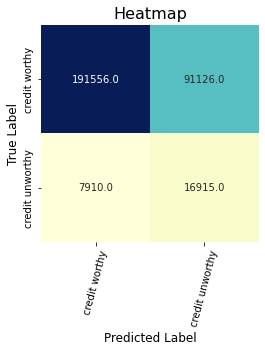


******************** Classification report ***********************
                 precision    recall  f1-score   support

  credit worthy       0.96      0.68      0.79    282682
credit unworthy       0.16      0.68      0.25     24825

       accuracy                           0.68    307507
      macro avg       0.56      0.68      0.52    307507
   weighted avg       0.90      0.68      0.75    307507



In [44]:
score_pip = pipe.score(train_df[feats].values, train_df['TARGET'])
print("score : {}".format(score_pip))
prob_pipe = pipe.predict_proba(train_df[feats].values)[:,1]
class_pipe = pipe.predict(train_df[feats].values)
evaluate_model(prob_pipe, class_pipe)

In [86]:
train_df[feats].iloc[0].values

array([ 8.30369674e-02,  2.62948593e-01,  1.39375780e-01, -6.37000000e+02,
       -9.46100000e+03, -2.12000000e+03,  6.07492668e-02,  0.00000000e+00,
        1.21977778e-01, -8.74000000e+02])

In [91]:
train_df[feats].iloc[0].values

array([ 8.30369674e-02,  2.62948593e-01,  1.39375780e-01, -6.37000000e+02,
       -9.46100000e+03, -2.12000000e+03,  6.07492668e-02,  0.00000000e+00,
        1.21977778e-01, -8.74000000e+02])

In [141]:

#math.trunc(pipe.predict_proba(train_df[feats].iloc[0:2].values[0][1]*100))
(pipe.predict_proba(train_df[feats].iloc[0:2].values)[:1]*100).astype(int)

/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([[32, 67]])

In [48]:
import joblib
joblib.dump(pipe, 'pipeline_credit.joblib')

['pipeline_credit.joblib']

In [142]:
class SklearnModelWrapper(mlflow.pyfunc.PythonModel):
    def __init__(self, model):
        self.model = model
    
    def predict(self, context, model_input):
        return (self.model.predict_proba(model_input)[:,1]*100).astype(int)


wrappedModel = SklearnModelWrapper(pipe)
from mlflow.models.signature import infer_signature
#signature = infer_signature(train_df[feats], pipe.predict_proba(train_df[feats].values))
signature = infer_signature(train_df[feats], wrappedModel.predict(None, train_df[feats].values))
#signature = infer_signature(train_df[feats], train_df['TARGET'])
conda_env = {
    "channels": ["conda-forge"],
    "dependencies": ["python=3.8.8",
                    "pip",
                    {"pip": ["mlflow",
                            "cloudpickle==1.6.0",
                           "psutil==5.8.0",
                            "scikit-learn==0.24.1",
                            "typing-extensions==3.10.0.2"]}],
    "name": "mlflow-env"
    }
#mlflow.sklearn.save_model(pipe, 'mlflow_model_proba', signature=signature)
mlflow.pyfunc.save_model(
        "mlflow_model_pyfunc", 
        python_model=wrappedModel, 
        signature=signature,
        conda_env=conda_env)

/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/nihal/Documents/Openclassrooms/Projets/P7/OC_P7/.venv/lib/python3.10/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ f

In [ ]:
from platform import python_version

print(python_version())